In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
import os
from os import path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import skimage.measure as meas

In [2]:
# %%
# save images with ellipse?
save_imgs = True

# display images in pop up window?
# NB: to go to the next image, click on the image and press any button.
#     You have to o through all images that are opened one after the other. 
#     If you close the pop up window, the script crashes. 
#     Choose the step size wisely. Or for looking at many images, I'd recommend
#     to save them (w/o displaying) and look at them in the folder.
show_imgs = True

# Additionally plot the tracked points. Normally not necessary. 
# Only for checking whether everything works correctly. 
plot_points = False

# Path to "videos" folder:
path_main = op.join('/u', 'fklotzsche', 'ptmp_link', 'Experiments', 'vMemEcc', 'Data', 'SubjectData', 'VME_S04', 'EyeTracking', 'Block2', '000')

# Path to save images to:
path_out = op.join(path_main, 'ell_out')
if not op.exists(path_out):
    os.makedirs(path_out)
    print('creating dir: ' + path_out) 

creating dir: /u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out


In [3]:
files = (file for file in os.listdir(path_main + '/ell_out'))
for file in files:
    print(file)

In [4]:
subID = 'VME_S04'
blockNR = '2'


# %%
# get tagged data from the csv:
# fname = op.join(path_main, '_Block'.join([subID, blockNR]) + 'DLC_resnet50_testNov6shuffle1_550000.csv')
fname = op.join(path_main, 'eye0DLC_resnet50_eye0Nov23shuffle1_625000.csv')
dlc_df = pd.read_csv(fname, skiprows=2)

In [5]:
# %%
ell_ = meas.EllipseModel()

def fun_(data): 
    data = np.reshape(data.to_numpy(), (-1,2)) #need to reshape each row into (Nx2) shapefor fitting the ellipse
    if np.isnan(np.sum(data)): # for NA values we write out zeros
        outp = [0] * 5
        return outp
    else:
        ell_.estimate(data)
        return ell_.params


# %%
# rowwise fit ellipse (this takes a while; ~30s on my machine)
dlc_df['ell_x'], dlc_df['ell_y'], dlc_df['ell_a'], dlc_df['ell_b'], dlc_df['ell_theta'] = zip(*dlc_df[['x', 'y', 
                                                                                                       'x.1', 'y.1', 
                                                                                                       'x.2', 'y.2', 
                                                                                                       'x.3', 'y.3', 
                                                                                                       'x.4', 'y.4', 
                                                                                                       'x.5', 'y.5', 
                                                                                                       'x.6', 'y.6', 
                                                                                                       'x.7', 'y.7']].apply(fun_, axis=1))

In [6]:
# %%
# get video:
# fname = op.join(path_main, '_Block'.join([subID, blockNR])+'DLC_resnet50_testNov6shuffle1_550000_filtered_labeled.mp4')
fname = op.join(path_main, 'eye0DLC_resnet50_eye0Nov23shuffle1_625000_labeled.mp4')
cap = cv2.VideoCapture(fname)

In [89]:
dlc_df.head()

,coords,x,y,likelihood,x.1,y.1,likelihood.1,x.2,y.2,likelihood.2,...,y.6,likelihood.6,x.7,y.7,likelihood.7,ell_x,ell_y,ell_a,ell_b,ell_theta
0,0,115.384087,88.958199,1.0,122.757812,91.813774,1.0,125.045776,97.840782,1.0,...,97.188416,1.0,109.109192,91.552376,1.0,116.163476,97.248789,9.328571,8.128495,0.314699
1,1,115.323387,88.942375,1.0,122.709358,91.800484,1.0,124.930519,97.845772,1.0,...,97.120056,1.0,109.048012,91.537498,1.0,116.069587,97.241094,9.304596,8.156712,0.304126
2,2,115.257385,88.991302,1.0,122.707443,91.876373,1.0,124.850739,97.917801,1.0,...,97.213310,1.0,108.981895,91.559753,1.0,115.984644,97.312454,9.351695,8.180093,0.298801
3,3,115.271675,88.918961,1.0,122.717178,91.769829,1.0,124.969452,97.800835,1.0,...,97.210968,1.0,108.975037,91.534828,1.0,116.068504,97.261775,9.364171,8.196945,0.314981
4,4,115.397369,88.923439,1.0,122.853119,91.829071,1.0,125.016144,97.855438,1.0,...,97.211761,1.0,109.074127,91.536201,1.0,116.166147,97.254996,9.335455,8.183769,0.327607


In [13]:
# %%

path_out = op.join(path_main, 'ell_out')
if not op.exists(path_out):
    os.makedirs(path_out)
    print('creating dir: ' + path_out) 

%matplotlib inline

plot_points = False
show_imgs = False

start = 1000   # 2000
end = 8000  # dlc_df.shape[0]
step = 1
for i in np.arange(start, end, step): #step through frames
    obs = dlc_df.iloc[i,:] #grab a single row from the df
    cap.set(1, i) # scroll to according frame in video
    rval, frame = cap.read() #grab frame
    cv2.ellipse(img=frame, 
                center=(int(obs['ell_x']), int(obs['ell_y'])), 
                axes=(int(obs['ell_a']), int(obs['ell_b'])),
                angle=np.rad2deg(obs['ell_theta']), 
                startAngle=0, 
                endAngle=360, 
                color=(int(250 * (1-obs['likelihood'])),1,int(250 * obs['likelihood'])),
                thickness=1)
    if plot_points:
        for j in range(8):
            if j==0: 
                add_str = ''
            else:
                add_str = '.'+str(j)
            cv2.circle(
                img=frame,
                center=(int(obs['x'+add_str]), int(obs['y'+add_str])),
                radius=1,
                color=(250, 250, (int(obs['likelihood']*100))), 
                thickness=-1)
    if save_imgs:
        cv2.imwrite(op.join(path_out, 'frame'+'{:06d}'.format(i)+'.jpg'), frame)
    if show_imgs:
        # cv2.namedWindow('image',cv2.WINDOW_NORMAL)
        # cv2.resizeWindow('image', 600, 600)
        # cv2.imshow('image', frame)
        cv2.imshow("test", frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


# %%
files = (file for file in os.listdir(path_main + '/ell_out'))

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001000.jpg
<class 'str'>
<class 'numpy.ndarray'>


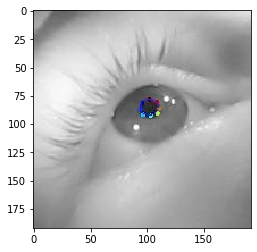

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001100.jpg
<class 'str'>
<class 'numpy.ndarray'>


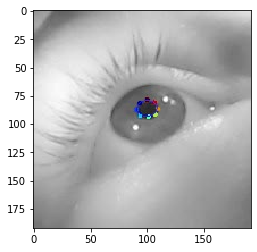

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001200.jpg
<class 'str'>
<class 'numpy.ndarray'>


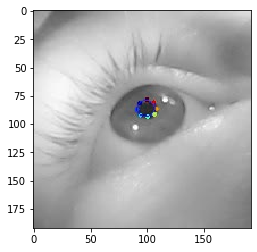

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001300.jpg
<class 'str'>
<class 'numpy.ndarray'>


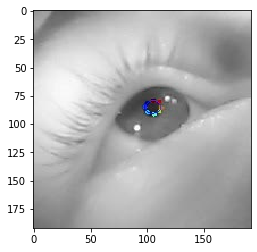

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001400.jpg
<class 'str'>
<class 'numpy.ndarray'>


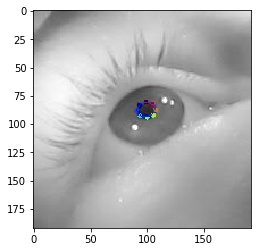

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001500.jpg
<class 'str'>
<class 'numpy.ndarray'>


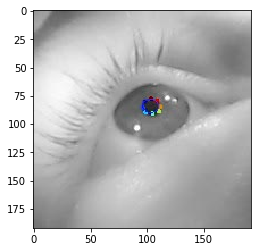

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001600.jpg
<class 'str'>
<class 'numpy.ndarray'>


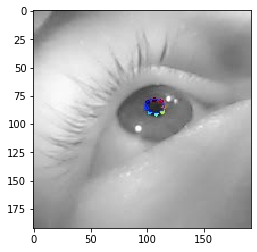

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001700.jpg
<class 'str'>
<class 'numpy.ndarray'>


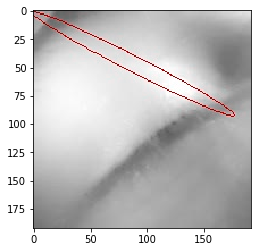

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001800.jpg
<class 'str'>
<class 'numpy.ndarray'>


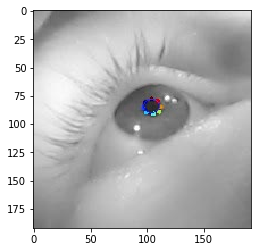

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame001900.jpg
<class 'str'>
<class 'numpy.ndarray'>


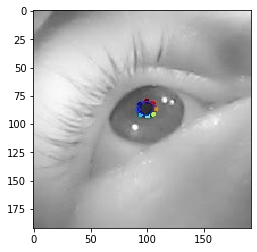

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002000.jpg
<class 'str'>
<class 'numpy.ndarray'>


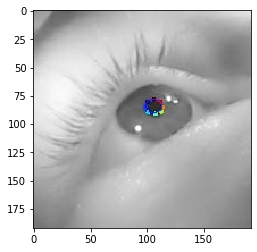

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002100.jpg
<class 'str'>
<class 'numpy.ndarray'>


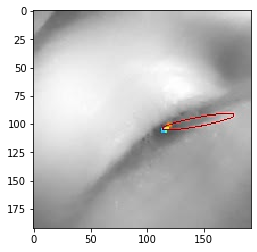

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002200.jpg
<class 'str'>
<class 'numpy.ndarray'>


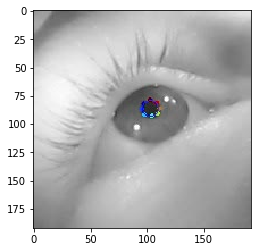

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002300.jpg
<class 'str'>
<class 'numpy.ndarray'>


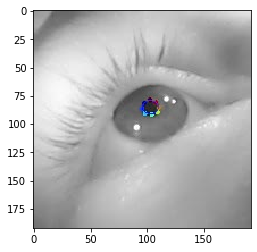

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002400.jpg
<class 'str'>
<class 'numpy.ndarray'>


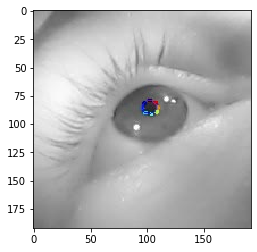

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002500.jpg
<class 'str'>
<class 'numpy.ndarray'>


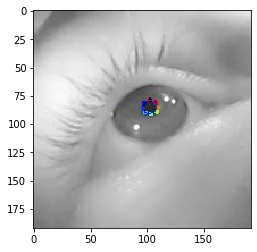

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002600.jpg
<class 'str'>
<class 'numpy.ndarray'>


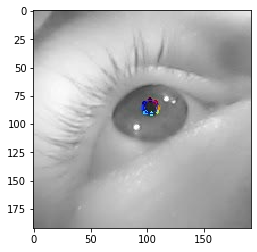

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002700.jpg
<class 'str'>
<class 'numpy.ndarray'>


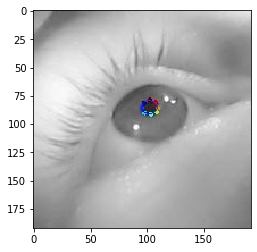

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002800.jpg
<class 'str'>
<class 'numpy.ndarray'>


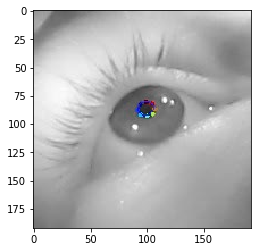

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame002900.jpg
<class 'str'>
<class 'numpy.ndarray'>


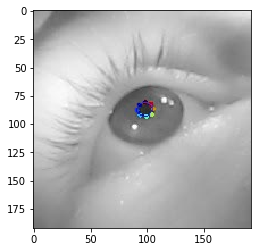

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003000.jpg
<class 'str'>
<class 'numpy.ndarray'>


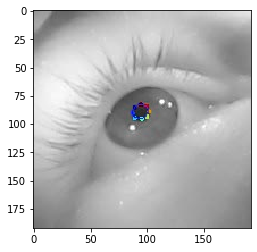

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003100.jpg
<class 'str'>
<class 'numpy.ndarray'>


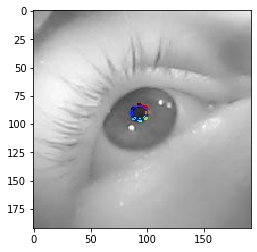

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003200.jpg
<class 'str'>
<class 'numpy.ndarray'>


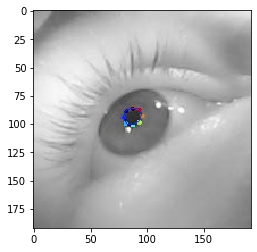

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003300.jpg
<class 'str'>
<class 'numpy.ndarray'>


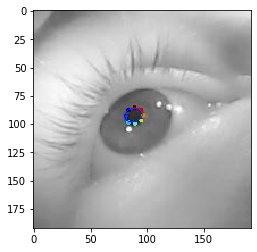

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003400.jpg
<class 'str'>
<class 'numpy.ndarray'>


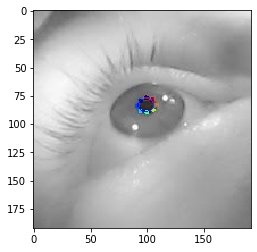

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003500.jpg
<class 'str'>
<class 'numpy.ndarray'>


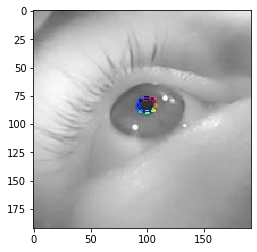

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003600.jpg
<class 'str'>
<class 'numpy.ndarray'>


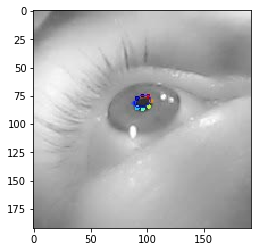

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003700.jpg
<class 'str'>
<class 'numpy.ndarray'>


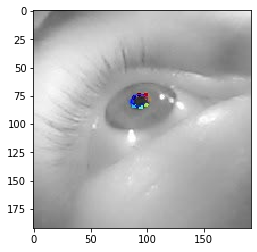

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003800.jpg
<class 'str'>
<class 'numpy.ndarray'>


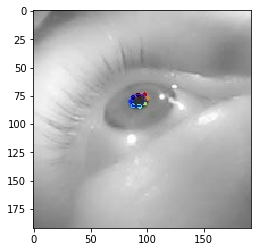

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame003900.jpg
<class 'str'>
<class 'numpy.ndarray'>


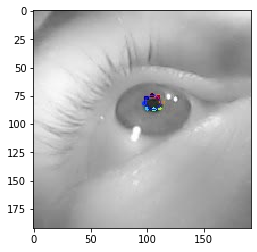

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004000.jpg
<class 'str'>
<class 'numpy.ndarray'>


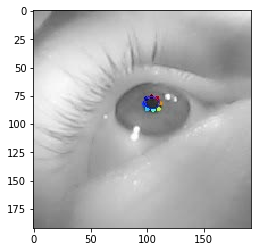

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004100.jpg
<class 'str'>
<class 'numpy.ndarray'>


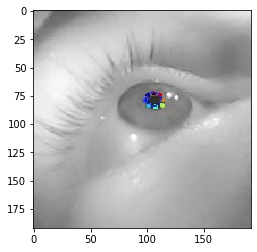

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004200.jpg
<class 'str'>
<class 'numpy.ndarray'>


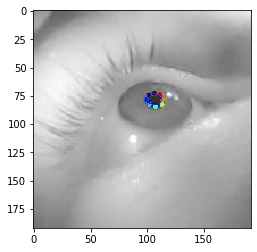

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004300.jpg
<class 'str'>
<class 'numpy.ndarray'>


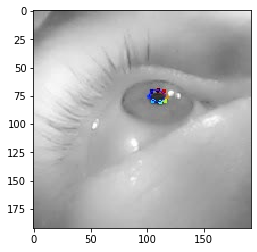

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004400.jpg
<class 'str'>
<class 'numpy.ndarray'>


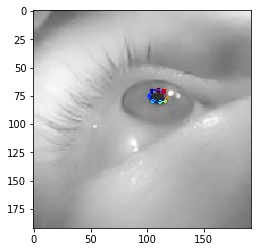

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004500.jpg
<class 'str'>
<class 'numpy.ndarray'>


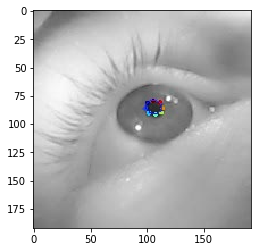

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004600.jpg
<class 'str'>
<class 'numpy.ndarray'>


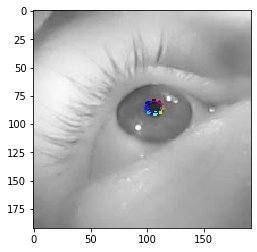

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004700.jpg
<class 'str'>
<class 'numpy.ndarray'>


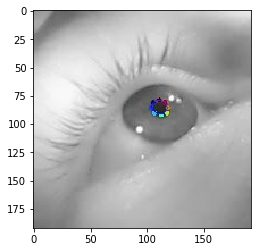

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004800.jpg
<class 'str'>
<class 'numpy.ndarray'>


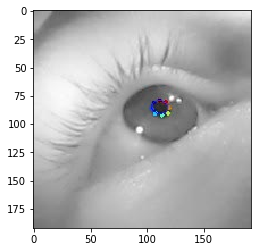

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame004900.jpg
<class 'str'>
<class 'numpy.ndarray'>


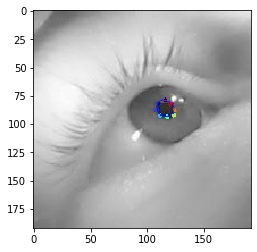

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005000.jpg
<class 'str'>
<class 'numpy.ndarray'>


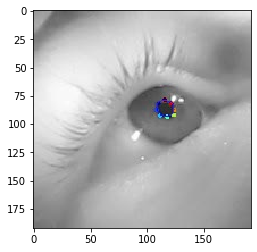

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005100.jpg
<class 'str'>
<class 'numpy.ndarray'>


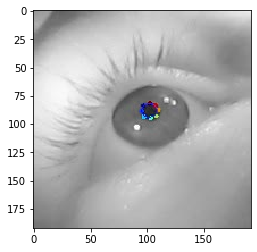

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005200.jpg
<class 'str'>
<class 'numpy.ndarray'>


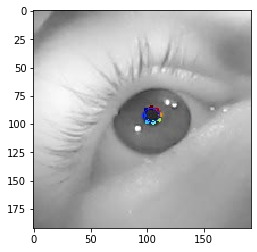

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005300.jpg
<class 'str'>
<class 'numpy.ndarray'>


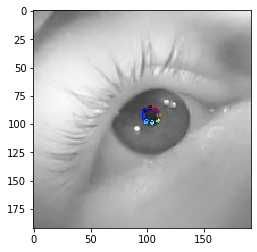

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005400.jpg
<class 'str'>
<class 'numpy.ndarray'>


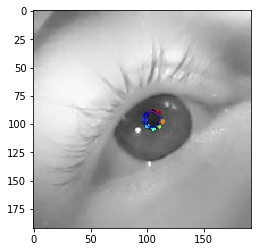

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005500.jpg
<class 'str'>
<class 'numpy.ndarray'>


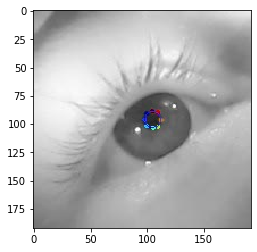

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005600.jpg
<class 'str'>
<class 'numpy.ndarray'>


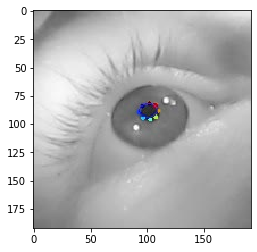

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005700.jpg
<class 'str'>
<class 'numpy.ndarray'>


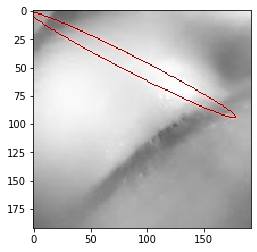

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005800.jpg
<class 'str'>
<class 'numpy.ndarray'>


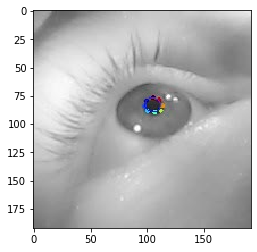

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame005900.jpg
<class 'str'>
<class 'numpy.ndarray'>


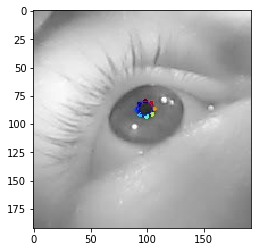

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006000.jpg
<class 'str'>
<class 'numpy.ndarray'>


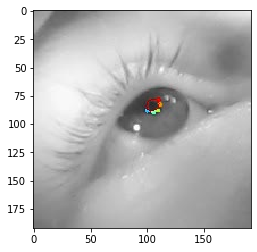

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006100.jpg
<class 'str'>
<class 'numpy.ndarray'>


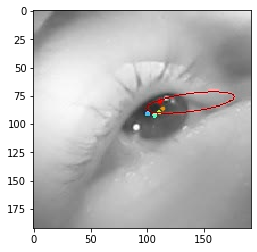

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006200.jpg
<class 'str'>
<class 'numpy.ndarray'>


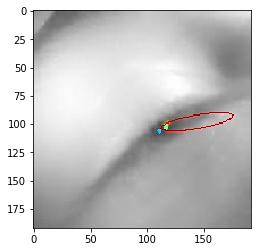

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006300.jpg
<class 'str'>
<class 'numpy.ndarray'>


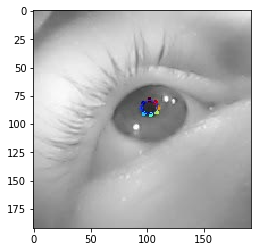

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006400.jpg
<class 'str'>
<class 'numpy.ndarray'>


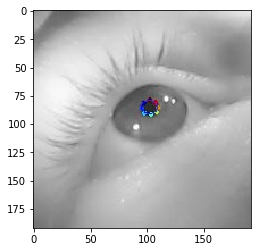

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006500.jpg
<class 'str'>
<class 'numpy.ndarray'>


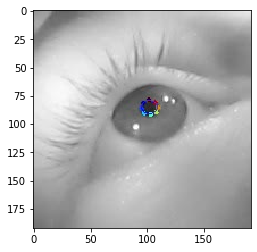

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006600.jpg
<class 'str'>
<class 'numpy.ndarray'>


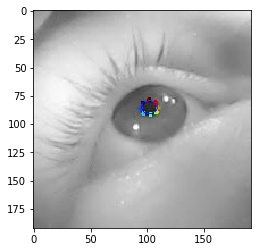

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006700.jpg
<class 'str'>
<class 'numpy.ndarray'>


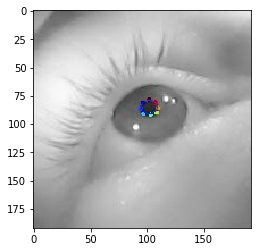

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006800.jpg
<class 'str'>
<class 'numpy.ndarray'>


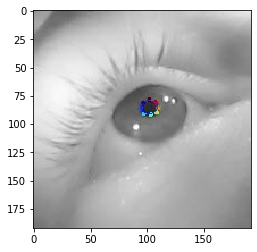

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame006900.jpg
<class 'str'>
<class 'numpy.ndarray'>


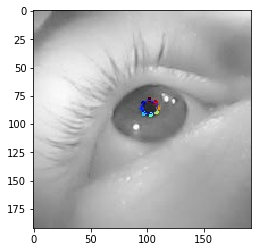

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007000.jpg
<class 'str'>
<class 'numpy.ndarray'>


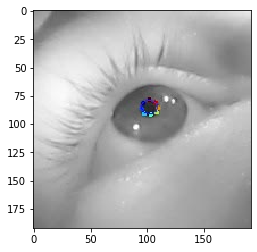

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007100.jpg
<class 'str'>
<class 'numpy.ndarray'>


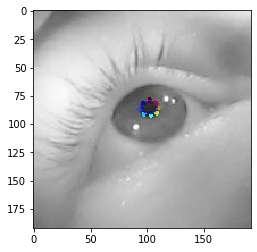

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007200.jpg
<class 'str'>
<class 'numpy.ndarray'>


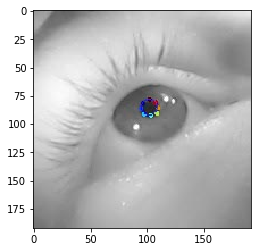

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007300.jpg
<class 'str'>
<class 'numpy.ndarray'>


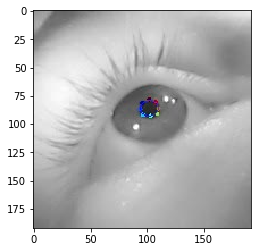

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007400.jpg
<class 'str'>
<class 'numpy.ndarray'>


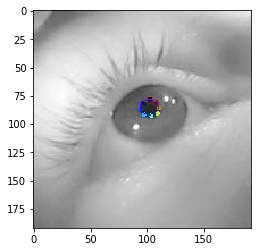

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007500.jpg
<class 'str'>
<class 'numpy.ndarray'>


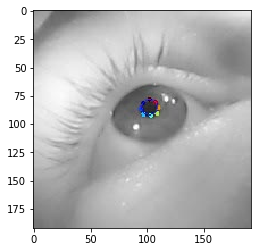

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007600.jpg
<class 'str'>
<class 'numpy.ndarray'>


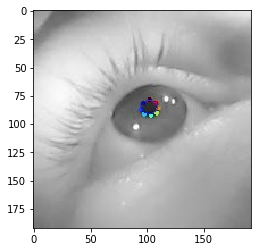

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007700.jpg
<class 'str'>
<class 'numpy.ndarray'>


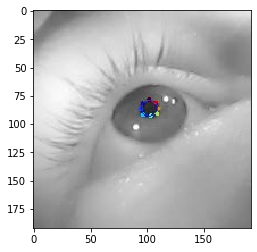

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007800.jpg
<class 'str'>
<class 'numpy.ndarray'>


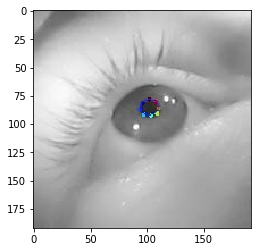

/u/fklotzsche/ptmp_link/Experiments/vMemEcc/Data/SubjectData/VME_S04/EyeTracking/Block2/000/ell_out/frame007900.jpg
<class 'str'>
<class 'numpy.ndarray'>


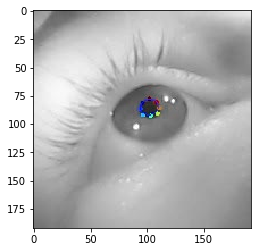

In [12]:
for file in sorted(files):
    print(path_main + '/ell_out/' + file)
    print(type(path_main + '/ell_out/' + file))
    img = cv2.imread(path_main + '/ell_out/' + file)
    print(type(img))
    plt.imshow(img)
    plt.show()

'00003'